## Bound Constraint Optimization

In [1]:
import math
import os
import logging
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append('..')


from opentps.core.data.images import CTImage
from opentps.core.data.images import ROIMask
from opentps.core.data.plan import ObjectivesList
from opentps.core.data.plan import PlanDesign
from opentps.core.data import DVH
from opentps.core.data import Patient
from opentps.core.data.plan import FidObjective
from opentps.core.io import mcsquareIO
from opentps.core.io.scannerReader import readScanner
from opentps.core.io.serializedObjectIO import saveRTPlan, loadRTPlan
from opentps.core.processing.doseCalculation.doseCalculationConfig import DoseCalculationConfig
from opentps.core.processing.doseCalculation.mcsquareDoseCalculator import MCsquareDoseCalculator
from opentps.core.processing.imageProcessing.resampler3D import resampleImage3DOnImage3D, resampleImage3D
from opentps.core.processing.planOptimization.planOptimization import BoundConstraintsOptimizer, IMPTPlanOptimizer
logger = logging.getLogger(__name__)

31/07/2024 03:35:15 PM - root - INFO - Loading logging configuration: /home/sophie/refactor/opentps/opentps_core/opentps/core/config/logger/logging_config.json
31/07/2024 03:35:15 PM - opentps.core._loggingConfig - INFO - Log level set: INFO
31/07/2024 03:35:15 PM - opentps.core.processing.imageProcessing.cupyImageProcessing - WARNING - Cannot import Cupy module
31/07/2024 03:35:16 PM - opentps.core.processing.registration.registrationMorphons - WARNING - cupy not found.
31/07/2024 03:35:16 PM - opentps.core.processing.registration.morphonsCupy - WARNING - cupy not found.
31/07/2024 03:35:16 PM - opentps.core.processing.C_libraries.libInterp3_wrapper - WARNING - cupy not found.


### Generic example: Box of water with squared targets

In [2]:
#Output path
output_path = 'Output'
if not os.path.exists(output_path):
    os.makedirs(output_path)
logger.info('Files will be stored in {}'.format(output_path))

ctCalibration = readScanner(DoseCalculationConfig().scannerFolder)
bdl = mcsquareIO.readBDL(DoseCalculationConfig().bdlFile)

patient = Patient()
patient.name = 'Patient'

ctSize = 150

ct = CTImage()
ct.name = 'CT'
ct.patient = patient


huAir = -1024.
huWater = ctCalibration.convertRSP2HU(1.)
data = huAir * np.ones((ctSize, ctSize, ctSize))
data[:, 50:, :] = huWater
ct.imageArray = data

roi = ROIMask()
roi.patient = patient
roi.name = 'TV'
roi.color = (255, 0, 0) # red
data = np.zeros((ctSize, ctSize, ctSize)).astype(bool)
data[100:120, 100:120, 100:120] = True
roi.imageArray = data

31/07/2024 03:35:16 PM - __main__ - INFO - Files will be stored in Output


### Design plan

In [3]:
beamNames = ["Beam1"]
gantryAngles = [0.]
couchAngles = [0.]

# method 1 : create or load existing plan (no workflow)

# Configure MCsquare
mc2 = MCsquareDoseCalculator()
mc2.beamModel = bdl
mc2.nbPrimaries = 5e4
mc2.ctCalibration = ctCalibration

# Load / Generate new plan
plan_file = os.path.join(output_path,"Plan_WaterPhantom_cropped_resampled.tps")

if os.path.isfile(plan_file):
    plan = loadRTPlan(plan_file)
    logger.info('Plan loaded')
else:
    planInit = PlanDesign()
    planInit.ct = ct
    planInit.gantryAngles = gantryAngles
    planInit.beamNames = beamNames
    planInit.couchAngles = couchAngles
    planInit.calibration = ctCalibration
    planInit.spotSpacing = 5.0
    planInit.layerSpacing = 5.0
    planInit.targetMargin = 5.0
    planInit.setScoringParameters(scoringSpacing=[2, 2, 2], adapt_gridSize_to_new_spacing=True)
    # needs to be called after scoringGrid settings but prior to spot placement
    planInit.defineTargetMaskAndPrescription(target = roi, targetPrescription = 20.) 
        
    plan = planInit.buildPlan()  # Spot placement
    plan.PlanName = "NewPlan"

    beamlets = mc2.computeBeamlets(ct, plan, roi=[roi])
    plan.planDesign.beamlets = beamlets

    beamlets.storeOnFS(os.path.join(output_path, "BeamletMatrix_" + plan.seriesInstanceUID + ".blm"))

    saveRTPlan(plan, plan_file)

plan.planDesign.objectives.addFidObjective(roi, FidObjective.Metrics.DMAX, 20.0, 1.0)
plan.planDesign.objectives.addFidObjective(roi, FidObjective.Metrics.DMIN, 20.5, 1.0)

solver = BoundConstraintsOptimizer(method='Scipy_L-BFGS-B', plan=plan, maxiter=50, bounds=(0.2, 50))

# Optimize treatment plan
doseImage, ps = solver.optimize()

# Compute DVH on resampled contour
target_DVH = DVH(roi, doseImage)
print('D95 = ' + str(target_DVH.D95) + ' Gy')
print('D5 = ' + str(target_DVH.D5) + ' Gy')
print('D5 - D95 =  {} Gy'.format(target_DVH.D5 - target_DVH.D95))

# center of mass
roi = resampleImage3DOnImage3D(roi, ct)
COM_coord = roi.centerOfMass
COM_index = roi.getVoxelIndexFromPosition(COM_coord)
Z_coord = COM_index[2]

31/07/2024 03:35:17 PM - opentps.core.data.plan._planDesign - INFO - Building plan ...
31/07/2024 03:35:17 PM - opentps.core.processing.planOptimization.planInitializer - INFO - Target is dilated using a margin of 5.0 mm. This process might take some time.
31/07/2024 03:35:17 PM - opentps.core.processing.imageProcessing.roiMasksProcessing - INFO - Using SITK to dilate mask.
31/07/2024 03:35:19 PM - opentps.core.data.plan._planDesign - INFO - New plan created in 1.6474130153656006 sec
31/07/2024 03:35:19 PM - opentps.core.data.plan._planDesign - INFO - Number of spots: 317
31/07/2024 03:35:19 PM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Prepare MCsquare Beamlet calculation
31/07/2024 03:35:21 PM - opentps.core.io.mhdIO - INFO - Write MHD file: /home/sophie/openTPS_workspace/Simulations/MCsquare_simulation/CT.mhd
31/07/2024 03:35:21 PM - opentps.core.io.mcsquareIO - INFO - Write plan: /home/sophie/openTPS_workspace/Simulations/MCsquare_simulation/PlanPenci

MCsquare: 7: [: Linux: unexpected operator





Initialization time: 0.352950 s 


Simulation of beamlet 305/317  
MC computation time: 2.155138 s 
Output computation time: 0.006393 s 

Simulation of beamlet 315/317  
MC computation time: 2.170127 s 
Output computation time: 0.006966 s 

Simulation of beamlet 297/317  
MC computation time: 2.213588 s 
Output computation time: 0.006778 s 

Simulation of beamlet 301/317  
MC computation time: 2.236511 s 
Output computation time: 0.006417 s 

Simulation of beamlet 309/317  
MC computation time: 2.243449 s 
Output computation time: 0.006878 s 

Simulation of beamlet 253/317  
MC computation time: 2.250987 s 
Output computation time: 0.006352 s 

Simulation of beamlet 312/317  
MC computation time: 2.262203 s 
Output computation time: 0.006149 s 

Simulation of beamlet 285/317  
MC computation time: 2.276419 s 
Output computation time: 0.005738 s 

Simulation of beamlet 293/317  
MC computation time: 2.276676 s 
Output computation time: 0.006525 s 

Simulation of beamlet 257/317  
MC 

### Display dose

31/07/2024 03:35:39 PM - opentps.core.processing.imageProcessing.roiMasksProcessing - INFO - Using SITK to dilate mask.


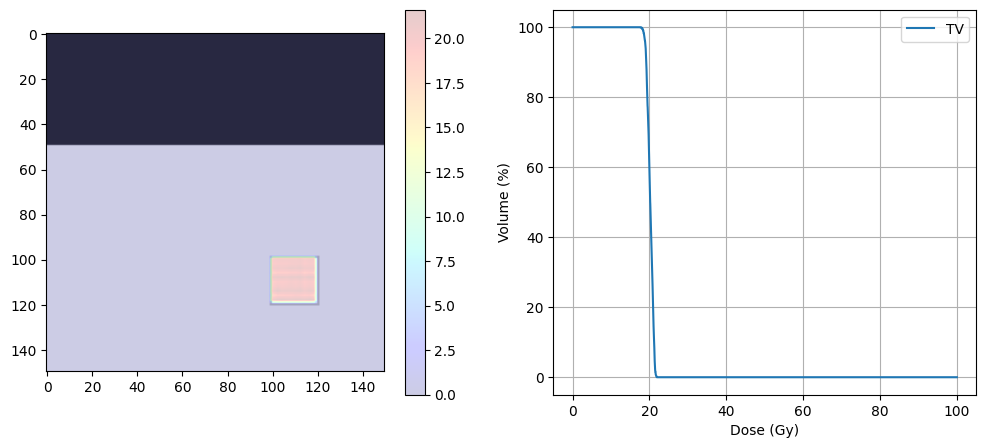

In [4]:
img_ct = ct.imageArray[:, :, Z_coord].transpose(1, 0)
contourTargetMask = roi.getBinaryContourMask()
img_mask = contourTargetMask.imageArray[:, :, Z_coord].transpose(1, 0)
img_dose = resampleImage3DOnImage3D(doseImage, ct)
img_dose = img_dose.imageArray[:, :, Z_coord].transpose(1, 0)

# Display dose
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(img_ct, cmap='gray')
ax[0].imshow(img_mask, alpha=.2, cmap='binary')  # PTV
dose = ax[0].imshow(img_dose, cmap='jet', alpha=.2)
plt.colorbar(dose, ax=ax[0])
ax[1].plot(target_DVH.histogram[0], target_DVH.histogram[1], label=target_DVH.name)
ax[1].set_xlabel("Dose (Gy)")
ax[1].set_ylabel("Volume (%)")
plt.grid(True)
plt.legend()
plt.show()
plt.savefig('img/BoundCon1',format = 'png')
plt.close()

![png](\assets\img_notebooks\BoundCon1.png)